# LA Traffic - Structured Data Analysis

*   IST 652
*   Prasad Kulkarni
*   Homework # 1
*   Date: July 27,2020




# Introduction

As the second largest city in the United States, Los Angeles has traffic challenges due to a large and growing population and an increase in the number of cars. A better understanding of the factors that contribute to accidents can help government officials, companies, citizens and other interested parties to understand how to make the city safer and more drivable.

The goal is to explore the trends and correlations between the data to provide useful information such as the most dangerous intersections, best/worst times of the day for accidents and other useful information.

# Analysis Questions and Sources


To guide our analysis we came up with a bunch of questions to answer in our analysis:

What are the most dangerous streets?  

What are the most common collision areas in Los Angeles? 

What are the best/worst days of the week for accidents? Month? 

## Sources

### Traffic dataset
The Los Angeles Traffic Collision Data is publicly available from Kaggle.com is owned by the City of Los Angeles. The dataset contains 481,568 incidents from 2010 to 2019
https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data

### Median Income dataset
For Median Income, incomes were pulled from the LA Chamber of Commerce website. They were then inputted into a CSV and merged into the original data frame.
https://lachamber.com/clientuploads/pdf/2018/18_BeaconReport_LR.pdf

# Loading and Cleaning the Data

## Data Cleaning
* Blank values and NAs were removed with the dropna() function.
* Time Occurred column was broken up into hours into a hours column
* Date was converted to DateTime and broken up into months, weekdays, and year columns.
* Year subsets were created in order to give flexibility to analyze any given year (la_2017 and la_2018 were concatenated and used to filter main dataset to show only data from 2017 and 2018)
* Location was broken up into longitude and latitude columns to make it easier to analyze with map visualizations.
* Date Occurred was dropped as well.

In [18]:
# INSTANT CLEAN 
# run this to get cleaned dataset

import pandas as pd
import numpy as np
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
import calendar
import plotly.graph_objs as go
import plotly.offline as offline


# Theme and styles for visuals
matplotlib.rcParams['font.family'] = "serif" # font
sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')


#Read in the csv with the LA traffic data from 2010-2019
la = pd.read_csv("/Users/prasadkulkarni/Documents/Syracuse University/IST 652/Assignments/HW1/LA weather/traffic-collision-data-from-2010-to-present.csv")


# add income and clean
income = pd.read_csv("/Users/prasadkulkarni/Documents/Syracuse University/IST 652/Assignments/HW1/LA weather/LAIncomeCouncil.csv")


# Clean income for calculations and make float type
income["Median Income"] = income["Median Income"].str.replace(",","")
income["Median Income"] = income["Median Income"].str.replace(" ","")
income["Median Income"] = income["Median Income"].str.replace('$','')
income['Median Income'].astype(float)

# merge income into LA dataset using the common column of Council Districts
la = la.merge(income, how = 'inner', on = ['Council Districts'])

# drop columns not used in project
la.drop(["DR Number", 
         "Area ID", 
         "Crime Code", 
         "Crime Code Description",
         "Premise Code",
         "Precinct Boundaries",
         "Date Reported", 
         "Neighborhood Councils (Certified)", 
         "Census Tracts", 
         "MO Codes", 
         "LA Specific Plans",
        "Reporting District"],
        axis=1, inplace=True)

# drop NAs in dataset
la.dropna(inplace=True)

# Victim Age needs to be integer
la['Victim Age'] = la['Victim Age'].astype(int)

# Zip Codes needs to be string
la['Zip Codes'] = la['Zip Codes'].astype(int).astype(str)

# Median Income needs to be float
la['Median Income'] = la['Median Income'].astype(float)

# Council District needs to be integer
la['Council Districts'] = la['Council Districts'].astype(int)

# Handling Date
# format date and time
la['Date'] =  pd.to_datetime(la['Date Occurred'],format='%Y/%m/%d')
# break up date to allow more variables for comparison
la['year'] = pd.DatetimeIndex(la['Date']).year # adds years column
la['month'] = pd.DatetimeIndex(la['Date']).month # adds month column
la['weekday']= pd.DatetimeIndex(la['Date']).dayofweek # adds weekday column
la['weekday'] = la['Date'].dt.day_name() #make it more readable

# break up by year subsets
la_2015 = la[la['year']== 2015]
la_2016 = la[la['year'] == 2016]
la_2017 = la[la['year'] == 2017]
la_2018 = la[la['year'] == 2018]
la_2019 = la[la['year'] == 2019]

frames = [la_2017, la_2018]
la = pd.concat(frames)

# Handling time, getting hours
la["Time Occurred"] = la["Time Occurred"].astype(str)
la["Time Occurred"] = [i[:2] if len(i) == 4 else i[0] for i in la["Time Occurred"]]
la["Time Occurred"] = la["Time Occurred"].astype(int)
la['hours'] = la['Time Occurred'] # adds hours column

# handling location column, break up into lat and long columns
la['Location'] = [ast.literal_eval(x) for x in la.Location]
la['longitude'] = [x['longitude'] for x in la.Location] # adds longitude column
la['latitude'] = [x['latitude'] for x in la.Location] # adds latitude column
la.longitude = la.longitude.astype(float)
la.latitude = la.latitude.astype(float)

# drop more columns not needed
la = la.drop(['Date Occurred'],axis=1)


# show final rows and columns for dataset, should now be 90845 rows and 19 columns
dataframe_rows, dataframe_cols = la.shape
print("The dimensions of the cleaned Los Angeles Collision dataset is",dataframe_rows,"rows and",dataframe_cols,"columns.")

The dimensions of the cleaned Los Angeles Collision dataset is 90845 rows and 19 columns.


In [3]:
# Theme and styles for visuals
matplotlib.rcParams['font.family'] = "serif" # font
sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')

In [19]:
# confirm years of data are in scope of 2017 and 2018
la.year.unique()

array([2017, 2018])

# Data Dictionary

A data dictionary with column names, description, data types, and processing steps is below. After everything was merged and cleaned, the final LA collision dataset for analysis had 90,845 rows and 19 columns.

In [20]:
# confirm data types are changed to desired type
la.dtypes

Time Occurred                   int64
Area Name                      object
Victim Age                      int64
Victim Sex                     object
Victim Descent                 object
Premise Description            object
Address                        object
Cross Street                   object
Location                       object
Zip Codes                      object
Council Districts               int64
Median Income                 float64
Date                   datetime64[ns]
year                            int64
month                           int64
weekday                        object
hours                           int64
longitude                     float64
latitude                      float64
dtype: object

In [21]:
# confirm there are no NULL values in cleaned dataset
pd.isnull(la).sum()

Time Occurred          0
Area Name              0
Victim Age             0
Victim Sex             0
Victim Descent         0
Premise Description    0
Address                0
Cross Street           0
Location               0
Zip Codes              0
Council Districts      0
Median Income          0
Date                   0
year                   0
month                  0
weekday                0
hours                  0
longitude              0
latitude               0
dtype: int64

# Data Summary

In [22]:
la.head() #show final dataset rows

,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Location,Zip Codes,Council Districts,Median Income,Date,year,month,weekday,hours,longitude,latitude
4920,13,Devonshire,74,F,A,STREET,NORDHOFF ST,LOUISE AV,"{'longitude': '-118.5113', 'human_address': '{...",18514,2,61000.0,2017-12-31,2017,12,Sunday,13,-118.5113,34.2359
4921,21,Devonshire,21,M,B,STREET,BALBOA BL,CHATSWORTH ST,"{'longitude': '-118.5023', 'human_address': '{...",19329,2,61000.0,2017-12-31,2017,12,Sunday,21,-118.5023,34.2648
4922,23,Devonshire,31,M,O,STREET,ZELZAH AV,TRIBUNE ST,"{'longitude': '-118.5234', 'human_address': '{...",19329,2,61000.0,2017-12-31,2017,12,Sunday,23,-118.5234,34.2686
4923,6,West Valley,54,M,O,STREET,SATICOY ST,RESEDA BL,"{'longitude': '-118.536', 'human_address': '{""...",18909,2,61000.0,2017-12-31,2017,12,Sunday,6,-118.5360,34.2084
4924,12,Topanga,28,M,W,STREET,PLATT AV,VICTORY BL,"{'longitude': '-118.6426', 'human_address': '{...",4283,2,61000.0,2017-12-30,2017,12,Saturday,12,-118.6426,34.1898


In [23]:
summary = la.describe()
summary = summary.transpose()
print(summary)

                     count          mean           std         min  \
Time Occurred      90845.0     13.536133      5.589630      1.0000   
Victim Age         90845.0     41.809720     16.156667     15.0000   
Council Districts  90845.0      8.344202      4.175006      1.0000   
Median Income      90845.0  56101.622544  16238.089311  33300.0000   
year               90845.0   2017.502515      0.499996   2017.0000   
month              90845.0      6.560262      3.440489      1.0000   
hours              90845.0     13.536133      5.589630      1.0000   
longitude          90845.0   -118.363911      0.105470   -118.6667   
latitude           90845.0     34.083449      0.108968     33.7070   

                          25%         50%         75%         max  
Time Occurred          9.0000     14.0000     18.0000     23.0000  
Victim Age            29.0000     39.0000     52.0000     99.0000  
Council Districts      5.0000      9.0000     12.0000     15.0000  
Median Income      45300.00

# Analysis: Time/Date

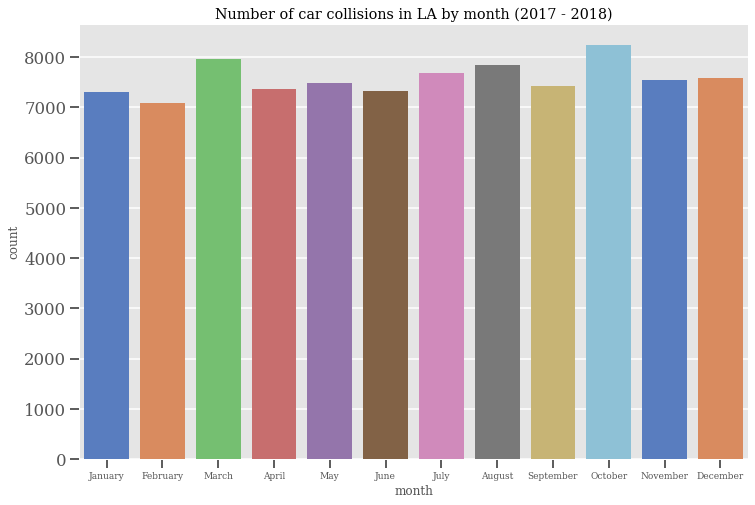

In [24]:
# Time, Collisions by month
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017 - 2018)');

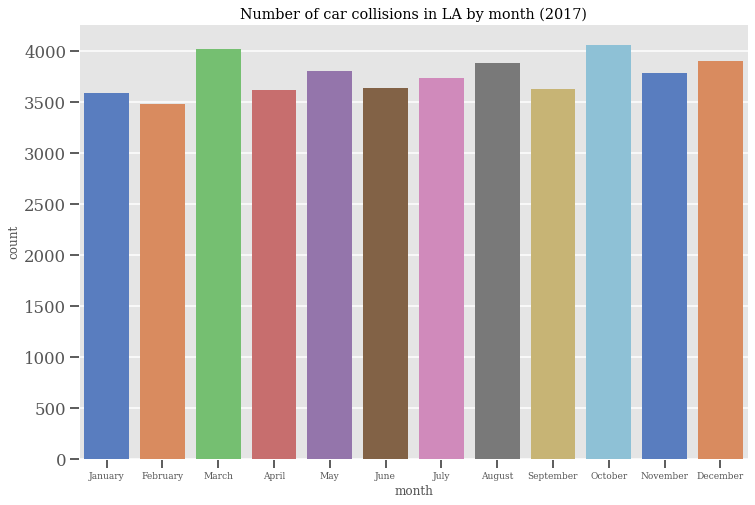

In [25]:
# Collisions by month in 2017 

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2017,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017)');



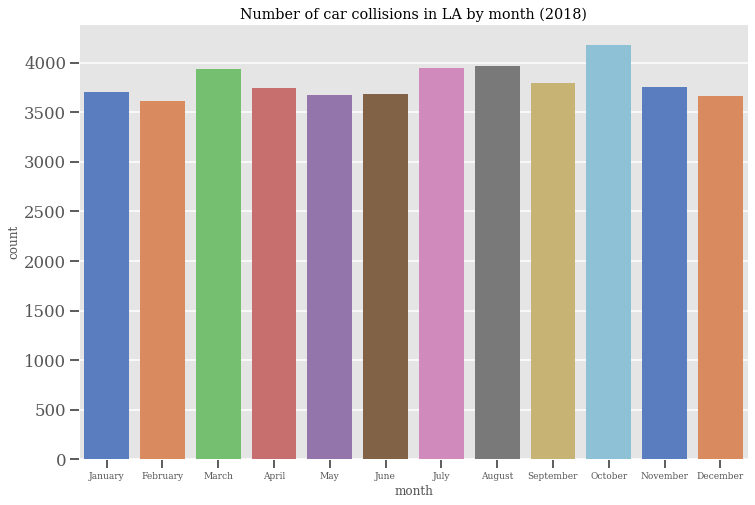

In [26]:
# Collisions by month in 2018

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2018,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2018)');

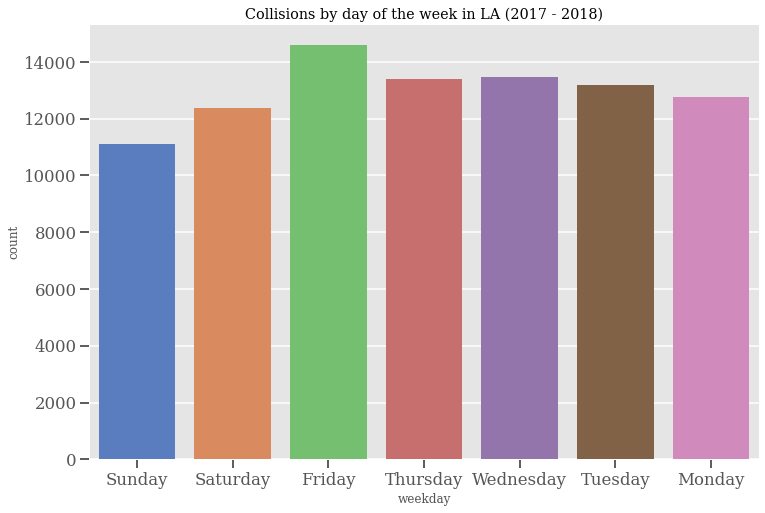

In [27]:
# collisions by weekday
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'weekday',data = la,palette='muted')
#ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], fontsize=10)
ax.set_title('Collisions by day of the week in LA (2017 - 2018)');

# Analysis: Location

77th Street    6318
Wilshire       5465
Southwest      5439
Olympic        5046
Newton         4969
Van Nuys       4690
N Hollywood    4652
Pacific        4530
Devonshire     4519
West Valley    4478
West LA        4384
Hollywood      4271
Mission        4129
Topanga        4120
Central        4062
Southeast      3655
Northeast      3580
Hollenbeck     3252
Rampart        3247
Foothill       3187
Harbor         2852
Name: Area Name, dtype: int64

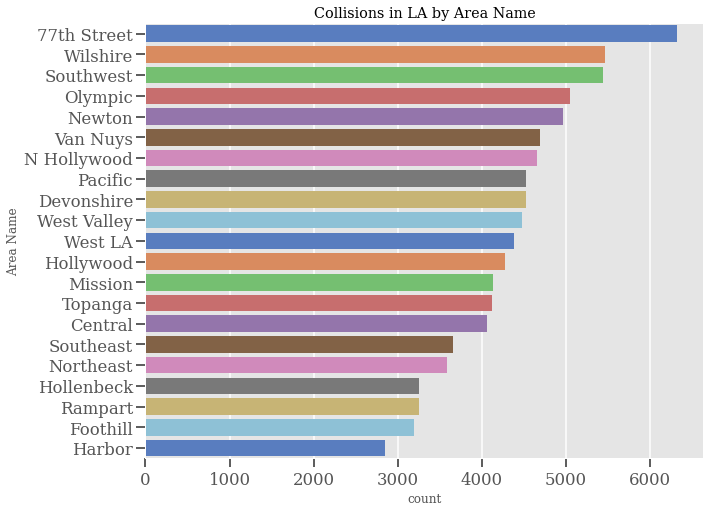

In [28]:
# collisions by area name, descending values, ORDERED

fig,ax = plt.subplots(figsize=(10,8))
descending_order = la['Area Name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,y="Area Name",order=descending_order, palette='muted')
ax.set_title('Collisions in LA by Area Name');

la['Area Name'].value_counts()

In [29]:
# use the Premise Description field to look at different locations of collisions, we can see that parking lot is the second most common type of collisions after street

la['Premise Description'].value_counts()

STREET                                                      86807
PARKING LOT                                                  3145
SIDEWALK                                                      328
ALLEY                                                         156
DRIVEWAY                                                      128
FREEWAY                                                        79
GAS STATION                                                    35
SINGLE FAMILY DWELLING                                         29
TRANSPORTATION FACILITY (AIRPORT)                              20
OTHER/OUTSIDE                                                  13
PARK/PLAYGROUND                                                12
GARAGE/CARPORT                                                 12
OTHER PREMISE                                                  11
PARKING UNDERGROUND/BUILDING                                   11
PEDESTRIAN OVERCROSSING                                         8
RESTAURANT

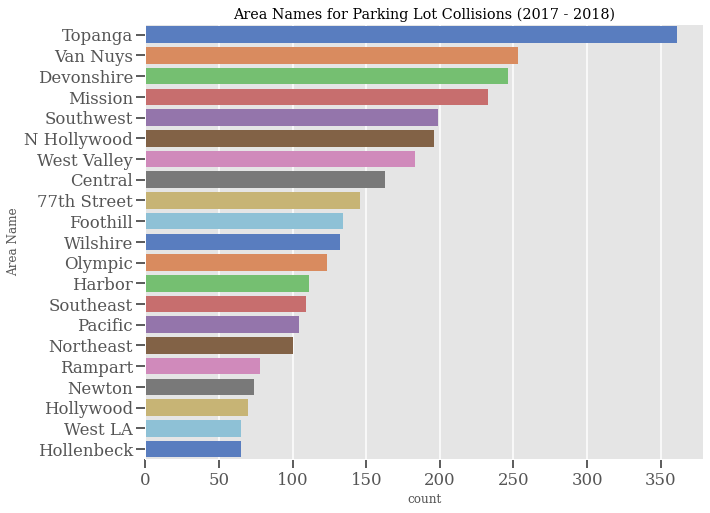

In [30]:
# Explore the area names of parking lot collisions to see if there is any commonality with the normal street collision areas

#look at parking lot only
la_parkinglot = la[la['Premise Description'] == 'PARKING LOT']

fig,ax = plt.subplots(figsize=(10,8))
descending_order = la_parkinglot['Area Name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la_parkinglot,y="Area Name",order=descending_order, palette='muted')
ax.set_title('Area Names for Parking Lot Collisions (2017 - 2018)');

#la['Area Name'].value_counts()

14    7836
12    7718
13    7698
9     7496
7     6642
3     6287
8     6126
6     5830
4     5730
10    5628
5     5563
2     5310
11    4748
15    4338
1     3895
Name: Council Districts, dtype: int64

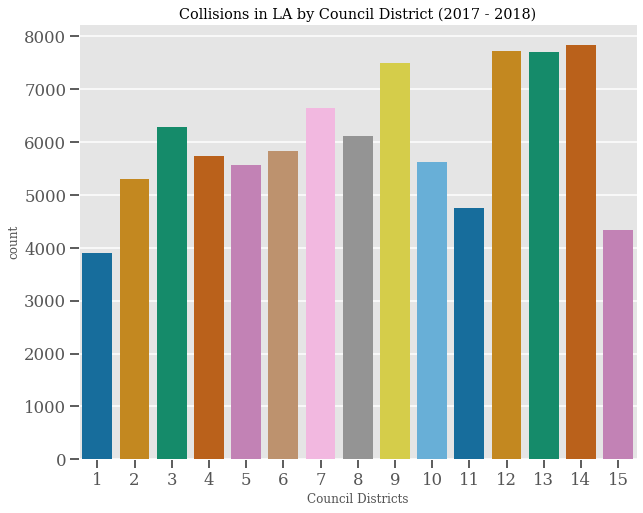

In [31]:
# Look at collisions by Council District 

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Council Districts",data=la,palette='colorblind')
ax.set_title('Collisions in LA by Council District (2017 - 2018)');

la['Council Districts'].value_counts()

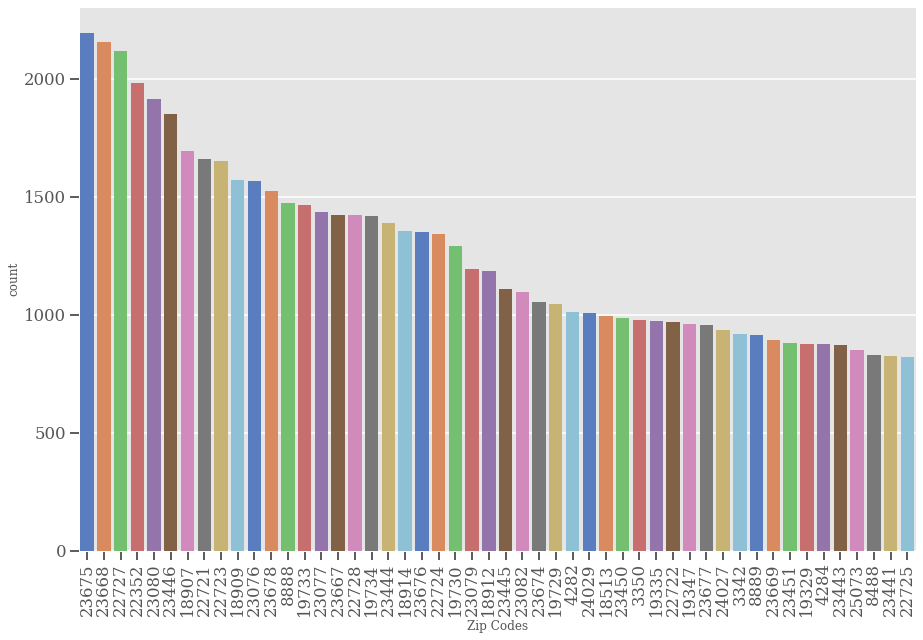

In [17]:
# Collisions by zip code

# TO DO, make top 50, descending order, add title, vertical X axis
descending_order = la['Zip Codes'].value_counts().sort_values(ascending=False).index[:50]
#sns.countplot(data=la,x="Zip Codes",order=descending_order, palette = 'muted')

#sort_values(ascending=0)[:10].plot(kind='bar')

fig,ax = plt.subplots(figsize=(15,10)), plt.xticks(rotation=90)
sns.countplot(x="Zip Codes",data=la, palette='muted', order=descending_order)
#ax.set_title('Collissions in LA by Zip Code (2017 - 2018)');

#la['Zip Codes'].value_counts()